# Quantum Nim Game

Transform a classical game into a quantum game!

## Table of Contents
- [Pre-requisites](#prereqisites)
- [Idea behind](#idea)
    - [The quantum phenomena](#quantumphenomena)
- [A Robot named Quadratibot](#robot)
	- [Math algorithm in the classical world](#mathclassical)
	- [Math algorithm in the quantum world](#mathquantum)
    - [QAOA](#qaoa)
    - [Grover](#grover)
- [Future](#future)
- [References](#ref)

## Pre-requisites <a class="anchor" id="prereqisites"></a>

Before starting, we need to install qiskit, for which we need to execute the following cell:

In [ ]:
%pip install qiskit
%pip install qiskit[visualization]
%pip install qiskit[optimization]
%pip install numpy
%pip install matplotlib

To check and import what we need :

In [2]:
# Import for Jupyter display
from IPython.display import Image, display

# Import auxiliary libraries
import numpy as np
import itertools
import math

# Import Qiskit
from qiskit import Aer, QuantumCircuit, execute, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.utils import QuantumInstance, algorithm_globals
import qiskit.tools.jupyter
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_state_qsphere
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library import MCMT
from qiskit.algorithms import QAOA, VQE, NumPyMinimumEigensolver

%qiskit_version_table

In order to initialize our quantum computer or quantum simulator just run the following cell :

In [3]:
# Initialize Real Quantum computer
# If you run qiskit on a real computer for the first time,
# you will need to create an account on https://quantum-computing.ibm.com/login
# and run the following lines with your token :
#IBMQ.save_account('MY_API_TOKEN')
#IBMQ.load_account()
#provider = IBMQ.get_provider('ibm-q')
#quantum_computer = provider.get_backend('ibmq_guadalupe')

# Initialize Qasm simulator backend
qasm = Aer.get_backend('qasm_simulator')

# Here we will use the local simulator --> Aer
backend = qasm  # Choose your backend : <quantum_computer> or <qasm>

# Set the randomness
algorithm_globals.random_seed = 42
# Create a QuantumInstance
simulator_instance = QuantumInstance(
    backend=backend,
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

## Idea behind <a class="anchor" id="idea"></a>

In 2021 for a the QC Hack[[7]](#7), a 24h Hackaton organized by the Quantum Coalition, a group of students of the university of Yale and Stanford. I created a quantum game.

I wanted to implemented a game using quantum mechanics. I already had a breed of idea about the famous Nim game[[4]](#4), it's a simple game with 2 players and ~11 sticks between then:

```
          \o/
           |
          / \
#######################
 | | | | | | | | | | | 
#######################
          \ /
           |
          /o\
```

Turn by turn, each player take 1 to 3 sticks. The goal is to NOT take the last stick !! Originally, this game can be automatize by classical computer to always win if the computer begins or against someone knowing the strategy. But what happens if we implement quantum rules ?

### The quantum phenomena <a class="anchor" id="quantumphenomena"></a>

Imagine having a multiple qubits quantum computer, on each qubit we can apply a simple _Not_ gate aka an `X` gate, a _Superposition_ gate aka `Hadamard` or `H` gate and an _Entanglement_ gate aka `CX` gate. That'll create a quantum circuit, then to have the current state of each qubit, we run our circuit and see which qubit collapse and whose not.

With our sticks, it's the same. On the first one you can apply an `X` and a `Hadamard` gate, on the 2nd one you can apply a `X`, `Hadamard` and a `CX` gate to be entangle with the previous one (Note: to use the `CX` it need to have a previous stick played on the current board).

Ok, we see the action we can do but what really happens in our game? If we continue our analogy, each action played in the quantum world also append in ours:
- `X` gate means taking the stick classically.
- `H` gate means taking the stick in superposition.
- `CX` gate means taking the stick in entanglement with the previous one, so the result of this one will depends by the result of the previous one. If the previous one has been took normally, so this one too. If the previous one has been took in superposition so this one will be.

And now, what happens to the stick whose not been took classically? In the current board, nobody can't do anymore actions on them. Only one action can be performed on each stick by board. At the end of the board when each stick has been taken. We run the quantum circuit and the game will continue with the sticks whose survived to generate a new board. And so on and so on, until not having sticks at all…

So, you can easily imagine having a strategy in this game it's not as easy as in the classical version and can easily gave a headache just trying to understand the rule without practicing. In practice the game is not that hard, and you'll easily understand the role of the different actions you can do each turn and their effects by practice.

A live version of this game exist on my website[[5]](#5), for free, not using cookie at all and not ads neither (because I don't like those):

In [4]:
from IPython.display import IFrame
IFrame('https://qnim-game.xtraorbitals.xyz/', width="100%", height=500)

But dont leave yet!! If you don't have headache and understood all of the rules __CONGRATULATION !!__ What's coming gonna be huge…

What's more fun that to create a weird game with complicate rules? Create a robot to be the opponent of this game with a very difficult AI using quantum algorithm and a bit of maths powder.

![This is fine](images_jupyter/fine.jpeg)

## A Robot named Quadratibot <a class="anchor" id="robot"></a>

During the hackaton, I didn't have the idea on how to create such a robot. The first version was a simple grover algorithm with simple scenario, that wasn't good at all and almost never use the quantum phenomena or not for good reasons. Then 6 months passed, I heard about quantum graphs theory and my mind started to boil…

After all, my game can be transpose into a graph where the node are the sticks and the level of the edges are the probabilities of _there is to be_ a stick or not. And what if the math formula wasn't that far from the classical one…

From there I started doing experiments.

### Math algorithm in the classical world <a class="anchor" id="mathclassical"></a>

In the classical game it has a simple rule to follow in order to easily win the game. The only thing that matter is to always go first and to always follow the rules.

In the most simple perfect configuration, a =<4 sticks block, you have to take 3 sticks. That's working whenever the can avoid to take the last stick of the block of 4 you have. Else you have to wait your opponent to make a mistake. 

Examples :

```
| | | | --> you can take 3 sticks and you gonna win :)

| | | --> you can take 2 sticks and you gonna win :)

|||| |||| ||| --> just take 2 sticks and you gonna win :)

|||| |||| |||| | --> you can't win unless your opponent make a mistake :'(
```

The math formula gonna be : `result = (total-1) % 4` and if `result = 0`, you only gonna wait a mistake from your opponent…

The idea now is to keep this formula and to adapt it in our Quantum context… let's see !

### Math algorithm in the quantum world <a class="anchor" id="mathquantum"></a>

In our quantum game, we not only have sticks left but also sticks of the past to take in account. The sticks who were previously take in superposition and entanglement. Our robot needs to remember its and the previous actions of the human player and then to calculate a number of sticks probability.

To do that, we define :
- sticks taken classically have a pound of 0
- sticks taken in superposition have a pound of 0.5
- sticks taken in entanglement have a pound of 0.5 ONLY IF a stick was previously taken in superposition (or in entanglement and the root base is a superposed stick)

In [5]:
# Terms
# "x" is a classical taken stick
# "/" is an superposed stick
# "¬" is an entangled stick

# Vars for the example
nb_stick_left = 10
past = ["/", "¬", "¬", "x", "/", "¬", "¬", "/"]

# Check number max of action allow
if nb_stick_left >= 3:
    max_stick = 3
else:
    max_stick = nb_stick_left

# Check the past
past.reverse()
poten_stick = nb_stick_left
for i in range(len(past)):
    if past[i] == "/":
        poten_stick += 0.5
    if past[i] == "¬":
        u = 1
        if len(past)-1 >= i+u:
            while past[i+u] == "¬":
                u += 1
            if past[i+u] == "/":
                poten_stick += 0.5

We also need to check the action of the last turn, that's gonna influence how many sticks the robot want to left :

In [6]:
# Check last turn
last_st = 0
if past[0] == "¬":
    u = 1
    while past[0+u] == "¬":
        u += 1
        if past[0+u] == "/":
            last_st = 0.5
if past[0] == "/":
        last_st = 0.5

Thanks to those analyzes our robot now knows that :
- number of sticks left on the actual board = 10 sticks
- number of potential sticks left = 13.5 sticks
- number max of action allow the robot can do this turn = 3 actions
- pound of the last turn = 0.5 sticks

In [7]:
print("Nb_stick = ", nb_stick_left)
print("Poten_stick = ", poten_stick)
print("Max_stick = ", max_stick)
print("Last_st = ", last_st)

Nb_stick =  10
Poten_stick =  13.5
Max_stick =  3
Last_st =  0.5


With all those informations we can add our rules (here each action equal 1) :
- min actions : `x + superposition + entanglement > 0`
- max actions : `x + superposition + entanglement <= number max of actions allow`
- quantum mod4 : `x + superposition <= ceil((potential sticks -0.5) % 4)`
- classical mod4 : `x + superposition + entanglement <= (number of sticks left -1) % 4`

Next we will see how to injected those rules into our quantum program by writing a Quadratic Program and resolving it with the Quantum Approximate Optimization Algorithm.

### QAOA <a class="anchor" id="qaoa"></a>

The QAOA means Quantum Approximate Optimization Algorithm[[2]](#2) is a quantum algorithm which is focus on solving combinatorial problem. A combinatorial problem is a problem who has a finite set of objects (or here actions) and the goal is to find the optimal object to solve the problem.
A QAOA can solve different sorts of problems, graph (such as the Max cut problem) or quadratic program such as ours problem.

A quadratic program[[3]](#3) gonna allow us to injected ours rules into the QAOA. Let's see how do we write it :

In [8]:
quadprog = QuadraticProgram(name="qnim")
quadprog.integer_var(name="x", lowerbound=0, upperbound=max_stick)
quadprog.integer_var(name="sup", lowerbound=0, upperbound=max_stick)
quadprog.integer_var(name="entangl", lowerbound=0, upperbound=max_stick)
quadprog.maximize(
    linear={"x":1, "sup":0.5, "entangl":last_st},
    quadratic={("sup", "entangl"):0.5}
)
# General constraints
quadprog.linear_constraint(linear={"x":1, "sup":1, "entangl":1}, sense=">", rhs=0, name="gen_min")
quadprog.linear_constraint(linear={"x":1, "sup":1, "entangl":1}, sense="<=", rhs=max_stick, name="gen_max")

# Mod4 constraints
if math.ceil((poten_stick-0.5)%4) > 0:
    quadprog.linear_constraint(linear={"x":1, "sup":1}, sense="<=", rhs=math.ceil((poten_stick-0.5)%4), name="qua_mod4")
if (nb_stick_left-1)%4 > 0:
    quadprog.linear_constraint(linear={"x":1, "sup":1, "entangl":1}, sense="<=", rhs=(nb_stick_left-1)%4, name="cla_mod4")

print(quadprog.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: qnim

Maximize
 obj: x + 0.500000000000 sup + 0.500000000000 _entangl + [ sup*_entangl ]/2
Subject To
 gen_min: x + sup + _entangl >= 0
 gen_max: x + sup + _entangl <= 3
 qua_mod4: x + sup <= 1
 cla_mod4: x + sup + _entangl <= 1

Bounds
       x <= 3
       sup <= 3
       _entangl <= 3

Generals
 x sup _entangl
End



We decide to maximize the number of actions the robot can play, those in order to not have an opposent who could be too careful but to have a _real_ player who want to win as soon as possible and can take risk.

Our rules defined above are now injected into our program and ready to be taking into account.
We can run our QAOA and wait for the result :

In [9]:
def get_quantum_solution_for(
    algo, quadprog: QuadraticProgram, quantumInstance: QuantumInstance, optimizer=None):
    _eval_count = 0

    def callback(eval_count, parameters, mean, std):
        nonlocal _eval_count
        _eval_count = eval_count
    
    # Create solver and optimizer
    solver = QAOA(optimizer=optimizer, quantum_instance=quantumInstance, callback=callback,)

    # Create optimizer for solver
    optimizer = MinimumEigenOptimizer(solver)

    # Get result from optimizer
    result = optimizer.solve(quadprog)
    return result, _eval_count

# Get QAOA result
final_result = []
qaoa_result, qaoa_eval_count = get_quantum_solution_for("QAOA", quadprog, simulator_instance)

# Format and print result
print("Solution found using the QAOA method:\n")
print(f"Maximum state is {qaoa_result.fval} actions")
print(f"Gates used are: ")
for nbActions, gate in zip(qaoa_result.x, qaoa_result.variable_names):
    print(f"\t{nbActions} actions of {gate}")
    for i in range(int(nbActions)):
        final_result.append(gate)

print(f"\nThe solution was found within {qaoa_eval_count} evaluations of QAOA.")
print("Gates to use : ", final_result)

Solution found using the QAOA method:

Maximum state is 1.0 actions
Gates used are: 
	1.0 actions of x
	0.0 actions of sup
	0.0 actions of entangl

The solution was found within 3 evaluations of QAOA.
Gates to use :  ['x']


Here the solution find is to use only 1 gate : an X gate. So the Robot gonna take a stick classically.

And so our Robot find a solution for this turn and then, next turn it gonna redo the same process. But what if the solution is to use more than 1 gate, what if the solution was to use an `H` and a `CX` gate ? How to use them, in what order ?
That's the limit of our program, it's set actions to do but not the order to do them…

The next process gonna give us the answer to fully finish to understand our does my Robot is working !

### Grover <a class="anchor" id="grover"></a>

You may have already heard that one of the many advantages of a quantum computer is database searching speedup. Indeed that's the role of the Grover's algorithm[[8]](#8).
Grover's algorithm uses the amplitude amplification to identify correct solution(s). Grovers uses several inputs and with a diffuser, amplifies the inputs which match the oracle to give the output.

In simple term, we will list any possible solutions from our actions (from the QAOA) and use Grover to find the best combinaison order.

It's not the first time, I'm using Grover in a context of game AI (see Quantum Pokemon Fight). Mainly because I find it easy to use and understand but also because in term of algorithm we can follow the logic by doing the quantum circuit all by ourself.

So for our example, let's assume the QAOA generated a list of 3 actions : 
- classical taking : an `X` gate
- superposition taking : an `H` gate
- entanglement taking : an `CX` gate

First of all we want to generate any combinaison allows :

In [10]:
output = ['x', 'sup', 'entangl']

lists_final = []
lists_full = list(itertools.permutations(output, len(output)))
for u in lists_full:
    if u not in lists_final:
        lists_final.append(u)
               
lists_final

[('x', 'sup', 'entangl'),
 ('x', 'entangl', 'sup'),
 ('sup', 'x', 'entangl'),
 ('sup', 'entangl', 'x'),
 ('entangl', 'x', 'sup'),
 ('entangl', 'sup', 'x')]

Now we can build our circuit.

The circuit gonna be composed by 3 structures :
- The Quantum RAM
- Our Algorithm & the Oracle
- The Diffuser

#### The QRAM <a class="anchor" id="qram"></a>

First thing first, how can we pass our inputs to Grover? We’ll use a QRAM (Quantum Random Access Memory), like classical RAM. It’ll allow us to map every input we want.

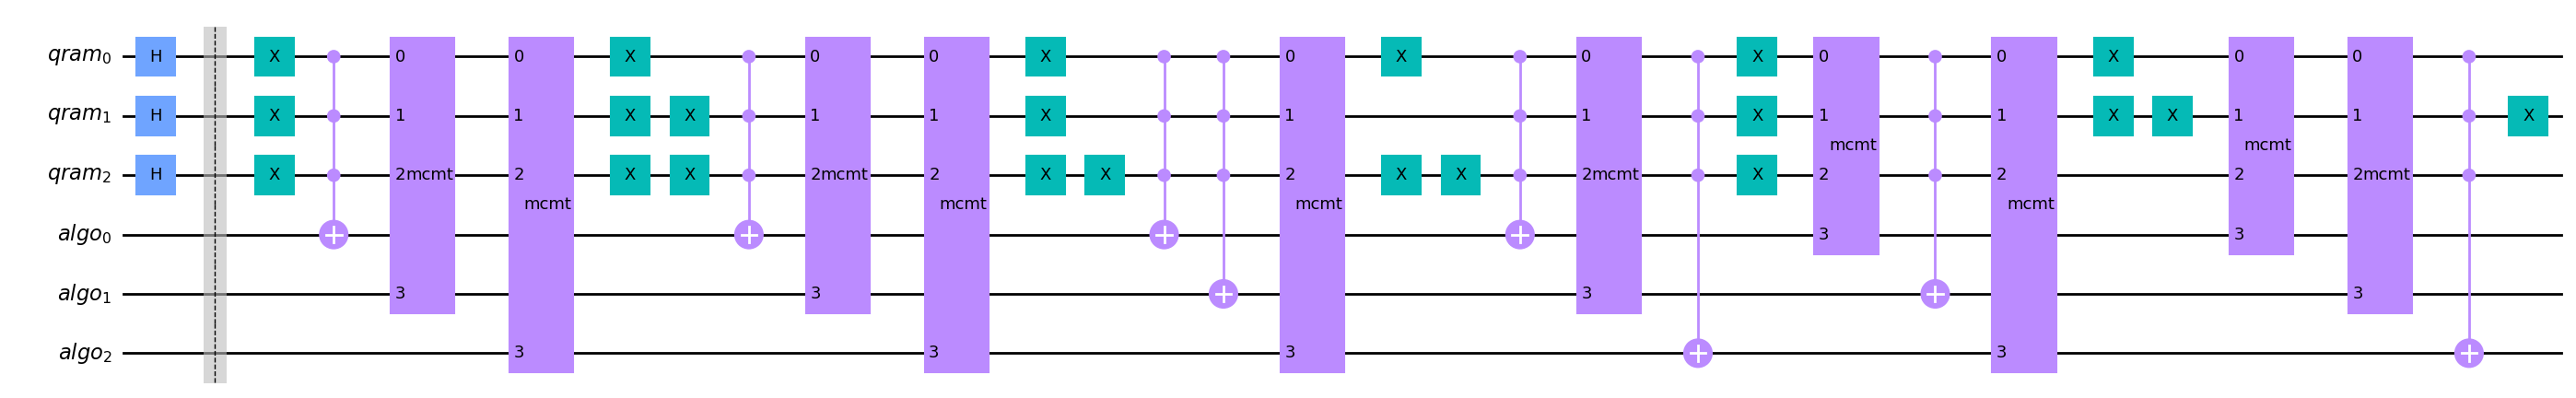

In [11]:
def ram(nqubits, lists_final):
    list_qram = [i for i in range(nqubits)]
    qram = QuantumRegister(nqubits, 'qram')
    qalgo = QuantumRegister(nqubits, 'algo')
    qc = QuantumCircuit(qram, qalgo)
    
    control_h = MCMT('h',nqubits, 1).to_gate()
    
    map_ram_2 = [['x', 'x'], ['o', 'x'], ['x', 'o'], ['o', 'o']]
    map_ram_3 = [['x', 'x', 'x'], ['o', 'x', 'x'], ['x', 'o', 'x'], ['o', 'o', 'x'], 
                 ['x', 'x', 'o'], ['o', 'x', 'o'], ['x', 'o', 'o'], ['o', 'o', 'o']]
    if len(bin(len(lists_final))[2:]) == 3:
        map_ram = map_ram_3
    if len(bin(len(lists_final))[2:]) == 2:
        map_ram = map_ram_2
    
    for i, m_ram in zip(range(len(lists_final)), map_ram):
        #qc.barrier()
        for index, gate in enumerate(m_ram):
            if gate == 'x':
                qc.x(qram[index])
        
        if lists_final[i][0] == 'x' or lists_final[i][0] == 'sup':
            qc.mcx(qram, qalgo[0])
        else:
            qc.append(control_h, [*list_qram, qalgo[0]])
        
        if len(lists_final[i]) == 3:
            if lists_final[i][1] == 'x':
                qc.mcx(qram, qalgo[1])
            elif lists_final[i][1] == 'intric':
                qc.mcx([qram[0], qram[1], qram[2], qalgo[0]], qalgo[1])
            else:
                qc.append(control_h, [*list_qram, qalgo[1]])
            
        if lists_final[i][-1] == 'x':
            qc.mcx(qram, qalgo[-1])
        elif lists_final[i][-1] == 'intric':
            if len(lists_final[i]) == 3:
                qc.mcx([qram[0], qram[1], qram[2], qalgo[1]], qalgo[-1])
            else:
                qc.mcx([qram[0], qram[1], qalgo[0]], qalgo[-1])
        else:
            qc.append(control_h, [*list_qram, qalgo[-1]])
        
        for index, gate in enumerate(m_ram):
            if gate == 'x':
                qc.x(qram[index])
    
    #print(qc.draw())
    U_s = qc.to_gate()
    U_s.name = "$Qram$"
    return U_s

# Show the content of the qram gate
len_qram = len(bin(len(lists_final))[2:])
qram = QuantumRegister(len_qram, 'qram')
qalgo = QuantumRegister(len_qram, 'algo')
qc = QuantumCircuit(qram, qalgo)
qc.h(qram)
qc.barrier()
qc.append(ram(len_qram, lists_final), [*[i for i in range(len_qram*2)]])
qc = qc.decompose(gates_to_decompose="$Qram$")
qc.draw(output="mpl", fold=-1)

#### The algorithm & Oracle

##### Algo
Now we have to define a rule who gonna apply a transformation to any solution in order to help the oracle to detect _This set is a good solution !_. But how to define such a rule ?

In other game many strategies can be played but for our Robot what we want is a good strategy to be (almost) sure to win every time.

This is a speculative strategy but it has the avantage to be simple :
- Quantum is about probabilities and our game also is. So what we want is to be in as much close as possible in the case of the classical rule. We have to the unquantumize the first qubit in any case and to make available to the human player a flat stick in order he can't play any entangled gate in our last play.
- To unquantumize a qubit, the most simple is to just add an `H`. But what if the qubit is alrealdy a flat qubit, we can keep the `H` and just add an `X` in order to gave it a negative phase who gonna be _neutralized_ by our Oracle.
- Adding those 2 gates only on the first qubit and ya... the algo is done.
For the 2nd qubit is doesn't matter because it's a standalone qubit so we can add any gate on it.
- For the last qubit we don't want to have a superposed actions or an entanglement action (if the previous one is a superposition). Indeed if so, the player could play action relative to this one and so adding hazardness. For a winning strategy hazardness is a nightmare. And to prevent that we in fact don't need to add anything.


    Here a the state of the first qubit :
    - In blue the transformation from a superposed qubit
    - In Yellow, the transformation from a flat qubit
    


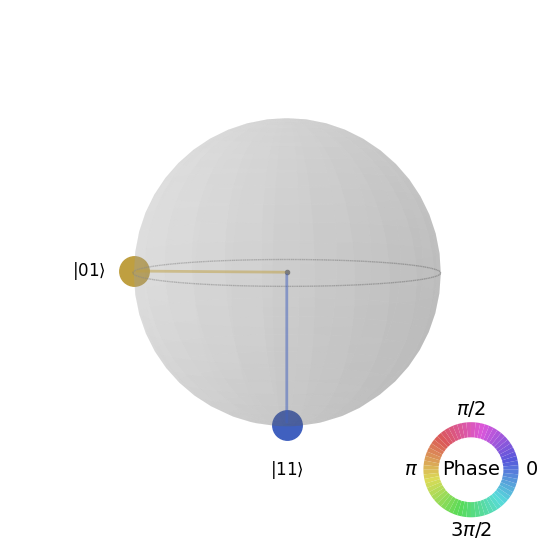

In [12]:
print(
    """
    Here a the state of the first qubit :
    - In blue the transformation from a superposed qubit
    - In Yellow, the transformation from a flat qubit
    """
)
qc = QuantumCircuit(2)
# From a superposed qubit
qc.h(0)
qc.h(0)
qc.x(0)
# From flat qubit
qc.x(1)
qc.h(1)
qc.x(1)
state = Statevector(qc)
plot_state_qsphere(state)

##### Oracle
Then we defined our Oracle to check the qubits need :
We know we don't need to check the 2nd qubit, we only need to check the first and the last one. So here the role of the Oracle is to make sure those qubits are always at the state `1`, in order to make sure to be in agreement with our defined stategy.

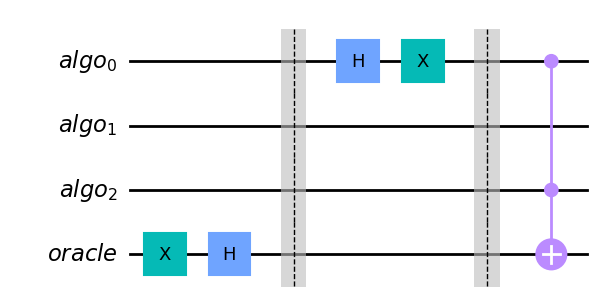

In [13]:
def algo(nqubits):
    qc = QuantumCircuit(nqubits)
    qc.h(0)
    qc.x(0)
    U_s = qc.to_gate()
    U_s.name = "$Algo$"
    return U_s

# Show the content of the qalgo gate and add the oracle
len_qram = len(bin(len(lists_final))[2:])
qalgo = QuantumRegister(len_qram, 'algo')
oracle = QuantumRegister(1, 'oracle')
qc = QuantumCircuit(qalgo, oracle)
qc.x(oracle)
qc.h(oracle)
qc.barrier()
qc.append(algo(len_qram), [*[i for i in range(len_qram)]])
qc.barrier()
qc = qc.decompose(gates_to_decompose="$Algo$")
qc.mcx([qalgo[0], qalgo[-1]], oracle)
qc.draw(output="mpl", fold=-1)

#### The diffuser

Before to put the diffuser we have to reverse our algo and our qram in order to reverse all the transformations we did to our qubits.

Finally our diffuser is going to read all of the inputs and if it sees an input with a negative phase, it’ll amplify this input to $3 * \theta$ (or $2 * \theta$ depending on its initial amplitude and number of states).

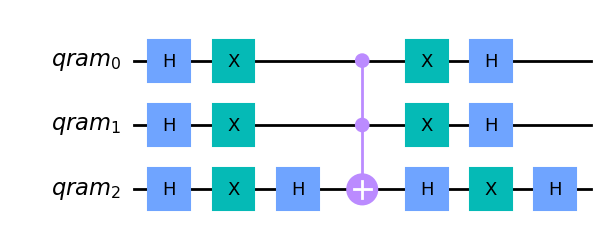

In [14]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits - 1)), nqubits - 1)
    qc.h(nqubits - 1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "$Diff$"
    return U_s

# Show the content of the qram gate
len_qram = len(bin(len(lists_final))[2:])
qram = QuantumRegister(len_qram, 'qram')
qc = QuantumCircuit(qram)
qc.append(diffuser(len_qram), [*[i for i in range(len_qram)]])
qc = qc.decompose(gates_to_decompose="$Diff$")
qc.draw(output="mpl", fold=-1)

#### Mixing everything together

Now that every pieces are ready, we can mix everything together to form our final circuit.

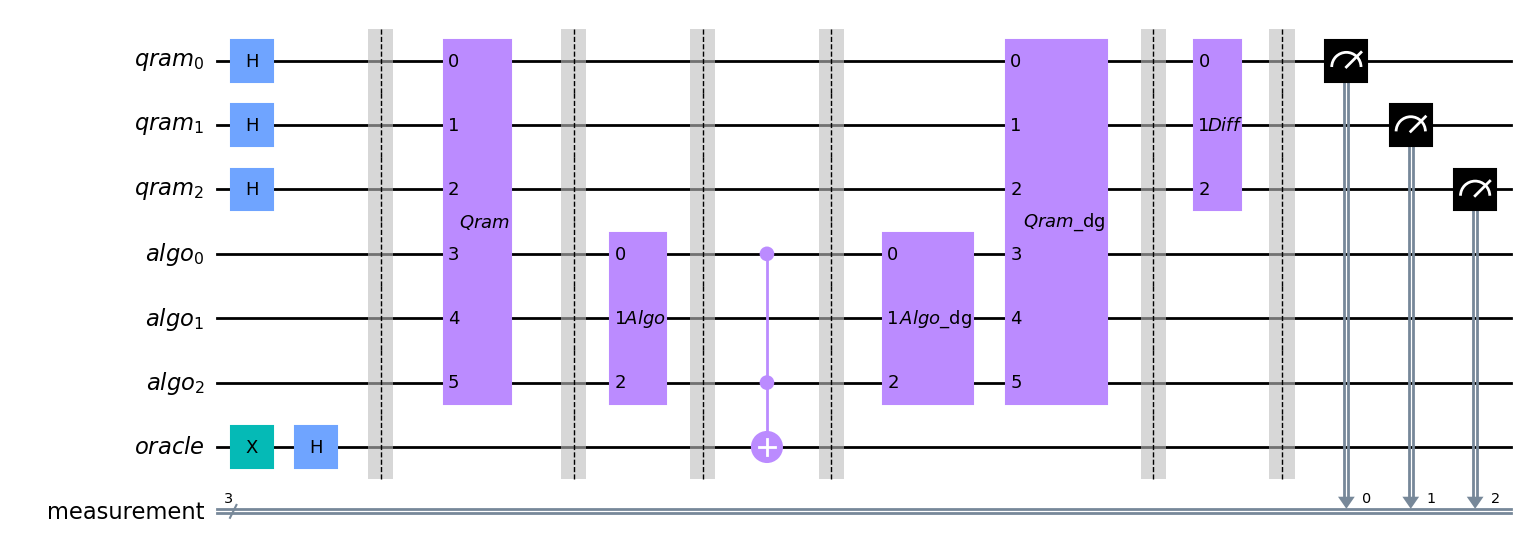

In [15]:
len_qram = len(bin(len(lists_final))[2:])
qram = QuantumRegister(len_qram, 'qram')
qalgo = QuantumRegister(len_qram, 'algo')
oracle = QuantumRegister(1, 'oracle')
c = ClassicalRegister(len_qram, 'measurement')

qc = QuantumCircuit(qram, qalgo, oracle, c)

# Init
qc.h(qram)
qc.x(oracle)
qc.h(oracle)
qc.barrier()

# Qram
qc.append(ram(len_qram, lists_final), [*[i for i in range(len_qram*2)]])
qc.barrier()
# Algorithm
qc.append(algo(len_qram), [*[i for i in range(len_qram, len_qram*2)]])
qc.barrier()

# Oracle
qc.mcx([qalgo[0], qalgo[-1]], oracle)
qc.barrier()

# Revert Algo + Qram
qc.append(algo(len_qram).inverse(), [*[i for i in range(len_qram, len_qram*2)]])
qc.append(ram(len_qram, lists_final).inverse(), [*[i for i in range(len_qram*2)]])
qc.barrier()

# Diffuser
qc.append(diffuser(len_qram), [*[i for i in range(len_qram)]])

# Measure of the ouputs
qc.barrier()
qc.measure(qram, c)

qc.draw(output="mpl", fold=-1)

Here the goal of Grover is to find the solutions who fit what we ask him to find and so its possible to have multiple good solutions with a certain probability. For our case I'm taking into account only the solution with the best probability :

{'010': 2, '000': 2, '001': 4, '011': 62, '111': 70, '100': 73, '110': 73, '101': 226}


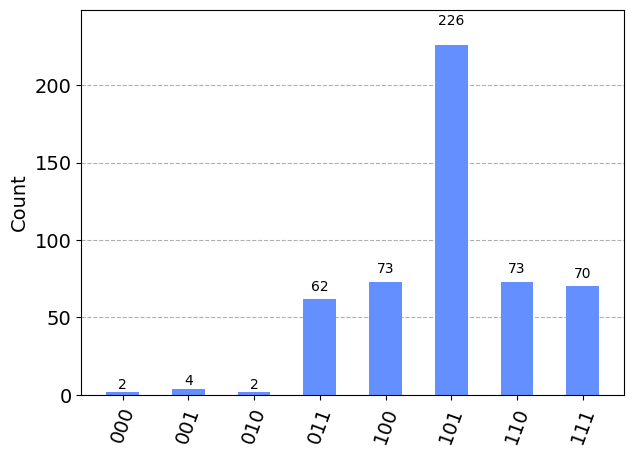

In [16]:
job = execute(qc, backend, shots=512, memory=True)
result_job = job.result()
result_count = result_job.get_counts()
result_memory = job.result().get_memory()
print(dict(sorted(result_count.items(), key=lambda item: item[1])))
plot_histogram(result_count)

Here the only solution with a good range is the solution number 5 (`101` in binary) and so its the combinaison : `'entangl', 'sup', 'x'`

Our Robot gonna take 3 sticks, first in entanglement with the previous sticks, second in superposition and last a classical taken.

## Furture of the Robot <a class="anchor" id="future"></a>

And done ! The Robot is finally finish, can run freely and hope win every single game !
The Robot is of course not perfect and the choices I did can be discuss as I mainly create it for the fun because… I had the idea.

Maybe one day I'll come with a new version of this Robot with a totally new algorithm or maybe not and it'll continue to run by itself in my lab… (the very complicate life of a gaming Robot).

In any case this Robot has its limits. Indeed it needs many qubits to run (~15 qubits) properly, in a real quantum computer it gonna have many errors and the QAOA can be very long to run with many rules.

![Santa errorless](images_jupyter/errorless.jpeg)

If you are still here, a very __HUGE THANKS !__

I know this article can be confusing and not easy to read. I tried to make it as much digest as possible.

Do not hesitate to test the game and try to win. I'm hoping you'll lose but let's try to prove me I'm wrong ;)

My game platform[[5]](#5) have a feedback section on the left, do not hesitate to give me a comment. Knowing people's trying and appreciating my games are always welcome.

## References <a class="anchor" id="ref"></a>
<a id="1">[1]</a> [Qiskit](https://qiskit.org): An Open-source Framework for Quantum Computing, 2019, [DOI: 10.5281/zenodo.2562110](https://doi.org/10.5281/zenodo.2562110)

<a id="2">[2]</a> [QAOA](https://qiskit.org/textbook/ch-applications/qaoa.html): Solving combinatorial optimization problems using QAOA, Qiskit Textbook

<a id="3">[3]</a> [QuadraticProgram](https://qiskit.org/documentation/optimization/tutorials/01_quadratic_program.html): Qiskit Textbook

<a id="4">[4]</a> [Nim](https://en.wikipedia.org/wiki/Nim): Wikipedia

<a id="5">[5]</a> [Games - Xtra Orbitals](https://games.xtraorbitals.xyz): Xtra Orbitals, 2021

<a id="6">[6]</a> [Quantum Nim Game](https://github.com/mickahell/quantum_Nim-game): GitHub

<a id="7">[7]</a> [Quantum Coalition Hack](https://www.quantumcoalition.io/qc-hack-2021): Website, 2021

<a id="8">[8]</a> [Grover](https://qiskit.org/textbook/ch-algorithms/grover.html): Grover's Algorithm, Qiskit Textbook

## Author
Michaël Rollin, [GitHub](https://github.com/mickahell), [Twitter](https://twitter.com/m1ckahell), [Linkedin](https://www.linkedin.com/in/michaelrollin/) 

 ### Cite as
If you use my work, please cite as : <pre>Quantum Nim Game: Quantum version of the classical Nim game, Michaël Rollin, 2023, DOI: <a href=https://doi.org/10.5281/zenodo.7769286>10.5281/zenodo.7769286</a></pre>
